In [154]:
import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

from train import conf
import glob
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import utils

import MI
import tqdm
import bvcopula
import vine as v

device = 'cuda:0'

In [214]:
animal = 'A0' #ST260 -> A0 for short
day = 1
day_name = f'D{day}' # DayN -> DN
# data_type = 'Ca' # Ca or spikes+kernel
exp_pref = f'{animal}_{day_name}'
exp_postfix = 'Y_3rd3rd' # given smth
path_models = f"{conf.path2outputs}/{exp_pref}_{exp_postfix}_gauss"
path_models

'/home/nina/outputs/A0_D1_Y_3rd3rd_gauss'

In [215]:
models_lists = lambda n: f"{path_models}/models_layer{n}.pkl"
WAICs = v.WAICs(models_lists)

In [216]:
# data['order'][28]

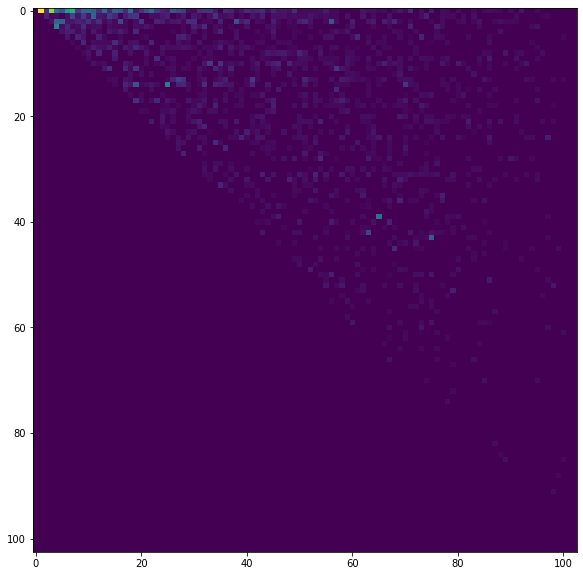

In [217]:
plt.figure(figsize=(10,10))
plt.imshow(-WAICs[:,:])
# plt.scatter(41,28,color='red')

In [218]:
dataset_name = f"{conf.path2data}/ST260_Day{day}_{exp_postfix}.pkl"
with open(dataset_name,'rb') as f:
    data = pkl.load(f)
Y = data['Y_test']
N = Y.shape[0]
print(N)
X = data['X']
# X,Y = utils.standard_loader(dataset_name)
N_points = 100
# train_x = torch.linspace(0.001,0.999,N_points).to(device=device).float()
train_x = torch.tensor(X, device=device).float()
# subset = torch.randperm(train_x.numel())[:N_points]
# train_x = train_x[subset]
weight_files = lambda layer,n: f"{path_models}/layer{layer}/model_{exp_pref}_{exp_postfix}_{layer}-{layer+n+1}.pth"

# likelihoods, vine = v.load(models_lists, weight_files, train_x)

# mc_size=3000
# sem_tol = 0.1

7157


In [219]:
def get_ll(X,Y):
    test_x = torch.tensor(X, device=device).float()
    test_y = torch.tensor(Y, device=device).float()
    _, vine = v.load(models_lists, weight_files, test_x)
    return vine.log_prob(test_y)

Y = data['Y']
X_train = data['X'][:Y.shape[0]]
ll_train = get_ll(X_train,Y)

Y = data['Y_test']
X_test = data['X'][-Y.shape[0]:]
ll_test = get_ll(X_test,Y)

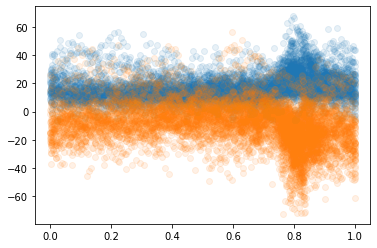

In [220]:
order = np.argsort(X_train)
plt.scatter(X_train[order],ll_train.cpu().numpy()[order],alpha=0.1)
order = np.argsort(X_test)
plt.scatter(X_test[order],ll_test.cpu().numpy()[order],alpha=0.1)

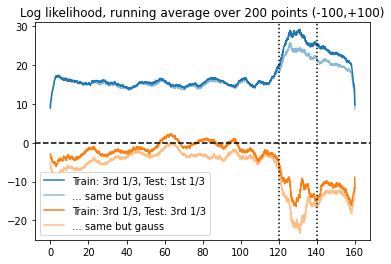

In [221]:
size_points = 200
discrete_filter = np.ones(size_points)*1/size_points
order = np.argsort(X_train)
plt.plot(X_train[order]*160,
         np.convolve(ll_trainA.cpu().numpy()[order],discrete_filter,mode='full')\
         [-1+size_points//2:-size_points//2],
        label='Train: 3rd 1/3, Test: 1st 1/3', color='C0')
plt.plot(X_train[order]*160,
         np.convolve(ll_train.cpu().numpy()[order],discrete_filter,mode='full')\
         [-1+size_points//2:-size_points//2],
        label='... same but gauss', color='C0', alpha=0.5)
order = np.argsort(X_test)
plt.plot(X_test[order]*160,
         np.convolve(ll_testA.cpu().numpy()[order],discrete_filter,mode='full')\
         [-1+size_points//2:-size_points//2],
        label='Train: 3rd 1/3, Test: 3rd 1/3', color='C1')
plt.plot(X_test[order]*160,
         np.convolve(ll_test.cpu().numpy()[order],discrete_filter,mode='full')\
         [-1+size_points//2:-size_points//2],
        label='... same but gauss', color='C1', alpha=0.5)
plt.axhline(0,color='k',linestyle='dashed')
plt.axvline(120,color='k',linestyle='dotted')
plt.axvline(140,color='k',linestyle='dotted')
plt.ylim(-25,31)
plt.title('Log likelihood, running average over 200 points (-100,+100)')
plt.legend()

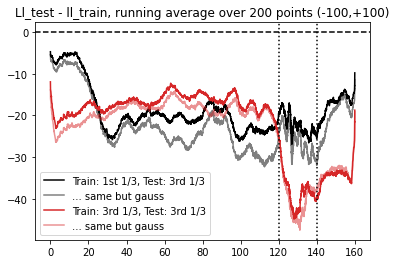

In [226]:
size_points = 200
discrete_filter = np.ones(size_points)*1/size_points
order_train = np.argsort(X_train)
order_test = np.argsort(X_test)
plt.plot(X_train[order]*160,
         np.convolve(ll1,discrete_filter,mode='full')\
         [-1+size_points//2:-size_points//2],
        label='Train: 1st 1/3, Test: 3rd 1/3', color='k')
plt.plot(X_train[order]*160,
         np.convolve(ll2,discrete_filter,mode='full')\
         [-1+size_points//2:-size_points//2],
        label='... same but gauss', color='k', alpha=0.5)
plt.plot(X_train[order]*160,
         np.convolve((ll_testA[order_test]-ll_trainA[order_train]).cpu().numpy(),discrete_filter,mode='full')\
         [-1+size_points//2:-size_points//2],
        label='Train: 3rd 1/3, Test: 3rd 1/3', color='C3')
plt.plot(X_train[order]*160,
         np.convolve((ll_test[order_test]-ll_train[order_train]).cpu().numpy(),discrete_filter,mode='full')\
         [-1+size_points//2:-size_points//2],
        label='... same but gauss', color='C3', alpha=0.5)

plt.axhline(0,color='k',linestyle='dashed')
plt.axvline(120,color='k',linestyle='dotted')
plt.axvline(140,color='k',linestyle='dotted')
# plt.ylim(-25,31)
plt.title('Ll_test - ll_train, running average over 200 points (-100,+100)')
plt.legend()

In [213]:
# ll_trainA = ll_train
# ll_testA = ll_test
# ll1 = (ll_testA[order_test]-ll_trainA[order_train]).cpu().numpy()
# ll2 = (ll_test[order_test]-ll_train[order_train]).cpu().numpy()

In [21]:
# %time entropy = vine.entropy(sem_tol=sem_tol, mc_size=mc_size, v=True)
# # vineC = v.CVine(vine.layers[1:],train_x,device=train_x.device)
# # %time entropyC = vineC.entropy(sem_tol=sem_tol, mc_size=mc_size, v=True)
# # data['order']
# vineC = v.CVine(vine.layers[1:],train_x,device=train_x.device)
# %time entropyC = vineC.entropy(sem_tol=sem_tol, mc_size=mc_size, v=True)

In [22]:
# x = train_x.cpu().numpy()*160
# # plt.title("Spikes with 600ms exp kernel, licks -9 fr shifted")
# plt.plot(x,entropy.cpu().numpy(),label="H(Y|X)")
# # plt.plot(x,entropyC.cpu().numpy(),label="H(Y|X,L)")
# # plt.plot(x,entropyCC.cpu().numpy(),label="H(Y|X,V,L)")
# plt.legend()

In [23]:
layers = len(vine.layers)
truncatedH = []
# vineC = v.CVine(vine.layers[1:],train_x,device=train_x.device)
Ns = [0,1,2,3,5,10,15,20,30,50,70,90,layers]
for i in Ns:
    %time entropy = vine.truncate(layers-i).entropy(sem_tol=sem_tol, mc_size=mc_size, v=False)
    #.stimMI(sR_mc_size=1800, s_mc_size=50, r_mc_size=5, sem_tol=sem_tol, v=True)
    #.entropy(sem_tol=sem_tol, mc_size=mc_size, v=False)
    truncatedH.append(entropy.cpu().numpy())
    print(entropy.cpu().numpy().mean())
with open(f"{home}/results/truncH{day}.pkl","wb") as f: #single variable BI_KSG:(MI,H(Y|X)) from uncond. data
    pkl.dump([Ns,train_x.cpu().numpy(),truncatedH],f)

CPU times: user 2.77 s, sys: 6 µs, total: 2.77 s
Wall time: 2.77 s
0.0
CPU times: user 25.9 s, sys: 16 ms, total: 25.9 s
Wall time: 25.9 s
-4.8708634
CPU times: user 26.5 s, sys: 108 ms, total: 26.6 s
Wall time: 26.6 s
-5.256904
CPU times: user 26.5 s, sys: 27.9 ms, total: 26.5 s
Wall time: 26.5 s
-5.337901
CPU times: user 27.6 s, sys: 23.8 ms, total: 27.6 s
Wall time: 27.6 s
-5.6802173
CPU times: user 29.4 s, sys: 7.84 ms, total: 29.4 s
Wall time: 29.4 s
-6.0512457
CPU times: user 31 s, sys: 60 ms, total: 31.1 s
Wall time: 31 s
-6.4248724
CPU times: user 33.8 s, sys: 59.9 ms, total: 33.8 s
Wall time: 33.8 s
-7.1922536
CPU times: user 35.6 s, sys: 129 µs, total: 35.6 s
Wall time: 35.6 s
-7.733443
CPU times: user 37.7 s, sys: 15.8 ms, total: 37.7 s
Wall time: 37.7 s
-8.287312
CPU times: user 38.1 s, sys: 8.04 ms, total: 38.1 s
Wall time: 38.1 s
-8.349821
CPU times: user 38.2 s, sys: 71.7 ms, total: 38.3 s
Wall time: 38.2 s
-8.356368
CPU times: user 38.1 s, sys: 27.9 ms, total: 38.1 s
Wa

102

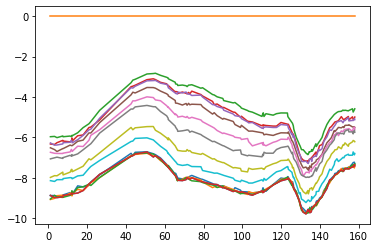

In [24]:
x = train_x.cpu().numpy()*160
order = np.argsort(x)
x = x[order]
plt.plot(x,entropy.cpu().numpy()[order])
for h in truncatedH:
    plt.plot(x,h[order])
# for h in entropies[:-2]:
#     mean = h.mean(0)
#     std = h.std(0)
#     plt.plot(x,mean[order])
#     plt.fill_between(x,mean[order]-std[order],mean[order]+std[order],alpha=0.5)
layers

In [25]:
D1 = np.array([56.83113046987128, 80.12078885833144, 82.21886233492826, 84.40436394055672, 84.87558542642425, 88.00782967097224, 89.69273889079463, 92.12250801202792, 96.01567143836508, 97.84428660115788, 99.45073510033504, 99.96360990510487, 100.0])
D2 = np.array([67.76638565475798, 81.01449252740379, 82.81174740724094, 88.96005248486861, 90.4896004228423, 92.54971063785608, 94.12865700367563, 94.57379984465527, 98.26399889495389, 99.53550587983408, 99.98184266551131, 100.00374451939797, 100.0])
D3 = np.array([66.97309745356736, 86.89210019998923, 88.4103160339022, 88.7060659479923, 89.95070567144036, 91.2815231985783, 92.57404426281637, 95.57289632152724, 97.515446547377, 99.73107688825309, 100.00199521183966, 100.00649473272384, 100.0])
D4 = np.array([67.90453133081701, 83.55882680279059, 88.69940854084408, 89.51099027359666, 90.92270877835773, 95.02250166568557, 96.23931131874633, 97.1329018604587, 98.06308907708389, 99.58821358531543, 100.03047506812916, 100.00479367572113, 100.0])

In [26]:
X,Y = utils.standard_loader(f"{conf.path2data}/ST260_Day{day}_unconditional.pkl")
singleH = np.empty((Y.shape[-1],2))
for i in range(Y.shape[-1]):
    singleH[i,:] = MI.BI_KSG(X.reshape((*X.shape,1)),Y[...,i].reshape((*X.shape,1)))
    print(singleH[i,:])
with open(f"{home}/results/singleH{day}.pkl","wb") as f: #single variable BI_KSG:(MI,H(Y|X)) from uncond. data
    pkl.dump(singleH,f)


[ 0.34675757 -0.34150196]
[ 0.34245989 -0.33634167]
[ 0.30840954 -0.30212658]
[ 0.2625423  -0.25640044]
[ 0.29818225 -0.29250836]
[ 0.28227362 -0.27593538]
[ 0.84694774 -0.84335823]
[ 0.61560714 -0.61109822]
[ 0.21309092 -0.20654881]
[ 0.21185753 -0.2059548 ]
[ 0.12520488 -0.1186772 ]
[ 0.83927924 -0.83513863]
[ 0.13137028 -0.12584251]
[ 0.1547812  -0.14846527]
[ 1.36340489 -1.3584168 ]
[ 0.24515021 -0.23993417]
[ 0.16457596 -0.15829558]
[ 0.13314942 -0.1269335 ]
[ 1.32107636 -1.31434851]
[ 0.16447517 -0.15834681]
[ 0.39991495 -0.39451651]
[ 0.21245379 -0.20632122]
[ 0.72887753 -0.72339564]
[ 0.18693612 -0.1810239 ]
[ 0.19552667 -0.18894797]
[ 0.13145399 -0.12506505]
[ 0.1237818  -0.11765023]
[ 0.1735284  -0.16731231]
[ 0.11626696 -0.10989985]
[ 0.04507753 -0.03872397]
[ 0.13509857 -0.12873637]
[ 0.33751072 -0.33296523]
[ 0.2516474  -0.24656471]
[ 0.0663534 -0.0597988]
[ 0.44554581 -0.44074665]
[ 0.46818261 -0.46459264]
[ 0.14989984 -0.14358259]
[ 0.27309338 -0.26894674]
[ 0.05349721 -

In [113]:
H1 = []
for d in range(1,5):
    with open(f"{home}/results/singleH{d}.pkl","rb") as f:
        singleH = pkl.load(f)
    H1.append(-singleH[:,1].sum())
H1

[23.118032647784247,
 23.437867509618993,
 17.062342978268717,
 18.750793761597656]

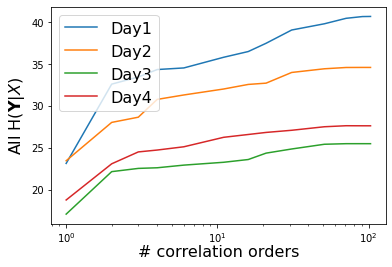

In [119]:
with open(f"{home}/results/singleH{day}.pkl","rb") as f:
    singleH = pkl.load(f)
Hs= -singleH[:,1].sum()
# plt.figure(figsize=(3,2))
# print([100*(H.mean()-Hs)/(truncatedH[-1].mean()-Hs) for H in truncatedH])
plt.semilogx([i+1 for i in Ns],H1[0]*D1/D1[0],color='C0',label='Day1')
plt.semilogx([i+1 for i in Ns],H1[1]*D2/D2[0],color='C1',label='Day2')
plt.semilogx([i+1 for i in Ns],H1[2]*D3/D3[0],color='C2',label='Day3')
plt.semilogx([i+1 for i in Ns],H1[3]*D4/D4[0],color='C3',label='Day4')
# plt.semilogx([i+1 for i in Ns],[100*(H.mean()-Hs)/(truncatedH[-1].mean()-Hs) for H in truncatedH[:]],
#              color='C3',linestyle='dashed',label='Day X')
plt.xlabel('# correlation orders',labelpad=0,fontsize=16)
plt.ylabel('All H($\mathbf{Y}|X$)',fontsize=16)
plt.legend(fontsize=16)
# plt.ylim(50,103)
# plt.yticks([50,60,70,80,90,100]);

In [27]:
# H = {}
# with open(f"{home}/results/HgV_spikes_ordering.pkl","rb") as f:
#     H = pkl.load(f)
# H['x'] = train_x.cpu().numpy()
# H['spikes_order_wv'] = entropy.cpu().numpy()
# H['spikes_order_gv'] = entropyC.cpu().numpy()
# H['spikes_order'] = data['order']
# H['ca_order_wv'] = entropy.cpu().numpy()
# H['ca_order_gv'] = entropyC.cpu().numpy()
# H['ca_order'] = data['order']
# H['raw_ca_wv'] = entropy.cpu().numpy()
# H['raw_ca_gv'] = entropyC.cpu().numpy()
# H['raw_ca_order'] = H['ca_order']
H['ca_order_truncated_MI'] = truncatedH 
# H['spikes_order_MI_xs'] = [0,1,2,3,4,5,10,15,20,30,40,50]
# H['raw_ca_MI_xs'] = [0,1,2,3,5,10,15,20,30,50]
with open(f"{home}/results/HgV_spikes_ordering.pkl","wb") as f:
    pkl.dump(H,f)
# H['x']

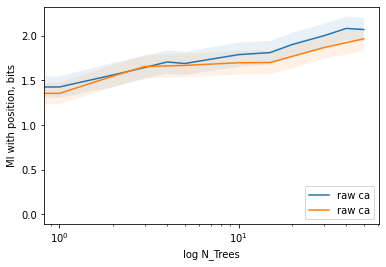

In [30]:
xs = H['spikes_order_MI_xs']
plt.plot(xs,[h[0] for h in H['spikes_order_truncated_MI']],label='raw ca')
plt.fill_between(xs,[h[0]-h[1] for h in H['spikes_order_truncated_MI']],
                [h[0]+h[1] for h in H['spikes_order_truncated_MI']],alpha=0.1)
xs = H['raw_ca_MI_xs']
plt.plot(xs,[h[0] for h in H['raw_ca_truncated_MI']],label='raw ca')
plt.fill_between(xs,[h[0]-h[1] for h in H['raw_ca_truncated_MI']],
                [h[0]+h[1] for h in H['raw_ca_truncated_MI']],alpha=0.1)
plt.xscale("log")
plt.xlabel('log N_Trees')
plt.ylabel('MI with position, bits')
plt.legend(loc=4)

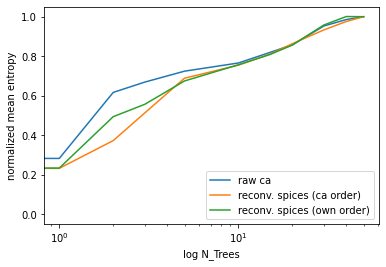

In [69]:
plt.plot([0,1,2,3,5,10,15,20,30,40,50],
         [h.mean()/H['raw_truncated'][-1].mean() for h in H['raw_truncated']],label='raw ca')
plt.plot([0,1,2,3,5,10,15,20,30,40,50],
         [h.mean()/H['ca_order_truncated'][-1].mean() for h in H['ca_order_truncated']],label='reconv. spices (ca order)')
plt.plot([0,1,2,3,5,10,15,20,30,40,50],
         [h.mean()/H['spikes_order_truncated'][-1].mean() for h in H['spikes_order_truncated']],label='reconv. spices (own order)')
plt.xscale("log")
plt.xlabel('log N_Trees')
plt.ylabel('normalized mean entropy')
plt.legend(loc=4)

In [9]:
# [len(copula_layers[i]) for i in range(108)]
copula_layers = vine.layers
c, c1 = 0, 0
for layer in copula_layers:
    for copulas in layer:
        c+= 1
        if len(copulas.copulas)==1:
            if copulas.copulas[0].__name__ == "IndependenceCopula":
                c1 += 1
print(c1,c,c1/c,c-c1)

4664 5356 0.8707991038088125 692


In [3]:
Hs = {}


#create inputs
# dataset_name = f"{conf.path2data}/ST260_Day1_sp200_gV.pkl"
# with open(dataset_name,'rb') as f:
#     data = pkl.load(f)
# X = data['X']
# Y = data['Y']
# N_points = 200
# train_x = torch.tensor(X, device=device).float()
# subset = torch.randperm(train_x.numel())[:N_points]
# train_x = train_x[subset].sort()
# x = train_x.cpu().numpy()
N_points = 200
train_x = torch.linspace(0.001,0.999,N_points).to(device=device).float()

Hs['x'] = train_x.cpu().numpy()

for n in [2,4,6]:
    exp_postfix = f'sp{n}00_gV' # given smth
    path_models = f"{conf.path2outputs}/{exp_pref}_{exp_postfix}"
    models_lists = lambda n: f"{path_models}/models_layer{n}.pkl"
    
    weight_files = lambda layer,n: f"{path_models}/layer{layer}/model_{exp_pref}_{exp_postfix}_{layer}-{layer+n+1}.pth"
    likelihoods, vine = v.load(models_lists, weight_files, train_x)
    %time entropy = vine.entropy(sem_tol=sem_tol, mc_size=mc_size, v=True)
    vineC = v.CVine(vine.layers[1:],train_x,device=train_x.device)
    %time entropyC = vineC.entropy(sem_tol=sem_tol, mc_size=mc_size, v=True)
    print(entropy.mean(),entropyC.mean())
    
    Hs[f's{n}00_wv'] = entropy.cpu().numpy()
    Hs[f's{n}00_gv'] = entropyC.cpu().numpy()
with open(f"{home}/results/HgV_vary_kernel_L.pkl","wb") as f:
    pkl.dump(Hs,f)

tensor(1.2538, device='cuda:0')
CPU times: user 2min, sys: 103 ms, total: 2min
Wall time: 2min
tensor(1.0919, device='cuda:0')
CPU times: user 1min 23s, sys: 58.3 ms, total: 1min 23s
Wall time: 1min 23s
tensor(-12.3167, device='cuda:0') tensor(-10.2643, device='cuda:0')
tensor(1.6741, device='cuda:0')
tensor(1.1820, device='cuda:0')
CPU times: user 4min 40s, sys: 195 ms, total: 4min 40s
Wall time: 4min 40s
tensor(1.3247, device='cuda:0')
CPU times: user 2min 40s, sys: 124 ms, total: 2min 40s
Wall time: 2min 40s
tensor(-17.8524, device='cuda:0') tensor(-15.1018, device='cuda:0')
tensor(1.8506, device='cuda:0')
tensor(1.3072, device='cuda:0')
tensor(1.0602, device='cuda:0')
CPU times: user 6min 23s, sys: 212 ms, total: 6min 23s
Wall time: 6min 23s
tensor(1.4590, device='cuda:0')
tensor(1.0321, device='cuda:0')
CPU times: user 3min 49s, sys: 140 ms, total: 3min 49s
Wall time: 3min 49s
tensor(-21.0773, device='cuda:0') tensor(-18.4477, device='cuda:0')


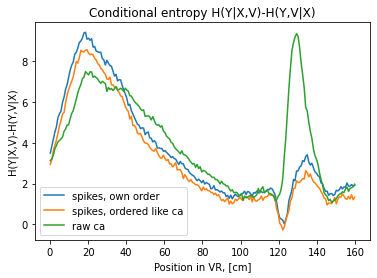

In [131]:
plt.title('Conditional entropy H(Y|X,V)-H(Y,V|X)')
plt.plot(H['x']*160,H['spikes_order_gv']-H['spikes_order_wv'],label='spikes, own order')
plt.plot(H['x']*160,H['ca_order_gv']-H['ca_order_wv'], label='spikes, ordered like ca')
plt.plot(H['x']*160,H['raw_ca_gv']-H['raw_ca_wv'], label='raw ca')
plt.xlabel('Position in VR, [cm]')
plt.ylabel('H(Y|X,V)-H(Y,V|X)')
plt.legend()

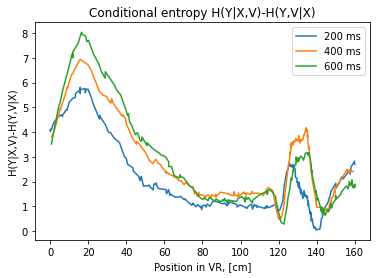

In [119]:
plt.title('Conditional entropy H(Y|X,V)-H(Y,V|X)')
plt.plot(Hs['s200_x']*160,Hs['s200_gv']-Hs['s200_wv'],label='200 ms')#-Hs['s200_wv'].mean())
plt.plot(Hs['s400_x']*160,Hs['s400_gv']-Hs['s400_wv'],label='400 ms')#-Hs['s400_wv'].mean())
plt.plot(Hs['s600_x']*160,Hs['s600_gv']-Hs['s600_wv'],label='600 ms')#-Hs['s600_wv'].mean())
plt.xlabel('Position in VR, [cm]')
plt.ylabel('H(Y|X,V)-H(Y,V|X)')
plt.legend()

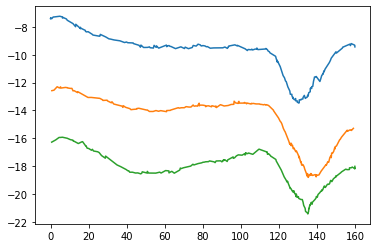

In [14]:
plt.plot(Hs['s200_x']*160,Hs['s200_gv'])#-Hs['s200_gv'].mean())
plt.plot(Hs['s400_x']*160,Hs['s400_gv'])#-Hs['s400_gv'].mean())
plt.plot(Hs['s600_x']*160,Hs['s600_gv'])#-Hs['s600_gv'].mean())

In [9]:
# _, vine = v.load(models_lists, weight_files, train_x, gp_particles=torch.Size([50]))
print(vine.layers[0][0].theta[0][0],vine.layers[0][0].theta[0].mean())
#tensor(-0.0466, device='cuda:1') tensor(-0.5867, device='cuda:1')
# vine.layers[0][0].theta[0][0].clone()

tensor(0.0002, device='cuda:1') tensor(4.3269e-05, device='cuda:1')


In [7]:
# with open(f"{home}/results/D1UxFU_vine.pkl","wb") as f:
#     pkl.dump([copula_layers,vine],f)
import copy
mc_size=4000
sem_tol = 0.05
N=10
entropies = torch.zeros_like(train_x).expand(torch.Size([N])+train_x.shape).cpu().numpy()
for i in range(N):
    _, vine = v.load(models_lists, weight_files, train_x, gp_particles=torch.Size([50]))
    print(vine.layers[0][0].theta[0][0],vine.layers[0][0].theta[0].mean())
    %time entropy = vine.entropy(sem_tol=sem_tol, mc_size=mc_size, v=True)
#     vineC = v.CVine(vine.layers[1:],train_x,device=train_x.device)
#     %time entropy = vineC.entropy(sem_tol=sem_tol, mc_size=mc_size, v=True)
#     vineC = v.CVine(vine.layers[2:],train_x,device=train_x.device)
#     %time entropyC = vineC.entropy(sem_tol=sem_tol, mc_size=mc_size, v=True)
#     print(entropy[0],entropy.mean())
    entropies[i] = entropy.cpu().numpy()
#     entropies[1,i] = entropyC.cpu().numpy()

tensor(0.7582, device='cuda:0') tensor(0.7340, device='cuda:0')
tensor(2.5004, device='cuda:0')
tensor(1.7738, device='cuda:0')
tensor(1.4407, device='cuda:0')
tensor(1.2525, device='cuda:0')
tensor(1.1207, device='cuda:0')
tensor(1.0219, device='cuda:0')
CPU times: user 8min 12s, sys: 248 ms, total: 8min 13s
Wall time: 8min 12s
tensor(0.7122, device='cuda:0') tensor(0.7324, device='cuda:0')
tensor(2.4606, device='cuda:0')
tensor(1.7618, device='cuda:0')
tensor(1.4297, device='cuda:0')
tensor(1.2410, device='cuda:0')
tensor(1.1120, device='cuda:0')
tensor(1.0155, device='cuda:0')
CPU times: user 8min 5s, sys: 204 ms, total: 8min 5s
Wall time: 8min 5s
tensor(0.7030, device='cuda:0') tensor(0.7300, device='cuda:0')
tensor(2.5257, device='cuda:0')
tensor(1.7762, device='cuda:0')
tensor(1.4473, device='cuda:0')
tensor(1.2520, device='cuda:0')
tensor(1.1170, device='cuda:0')
tensor(1.0176, device='cuda:0')
CPU times: user 8min 13s, sys: 228 ms, total: 8min 13s
Wall time: 8min 13s
tensor(0.6

In [17]:
# vineC = v.CVine(copula_layers[1:],train_x,device=train_x.device)
# %time entropyC = vineC.entropy(sem_tol=sem_tol, mc_size=mc_size, v=True)
# with open(f"{home}/results/H_Y_withconf.pkl","wb") as f:
#     pkl.dump([train_x.cpu().numpy(),entropies],f)
with open(f"{home}/results/H_gV_withconf.pkl","rb") as f:
    dat = pkl.load(f)

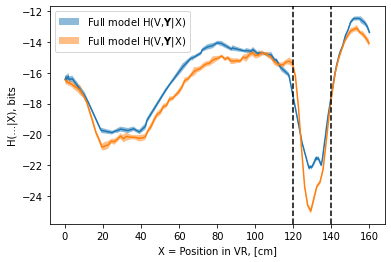

In [29]:
# x = data['Xr'][subset.cpu().numpy()]
# order = np.argsort(x)
# x = x[order]
# plt.plot(x,-entropy.cpu().numpy()[order])
# plt.plot(x,-entropyC.cpu().numpy()[order])
# plt.xlabel('time to entering reward zone, [sec]')
# plt.ylabel(r'$-H(Y,V|X)$')
# plt.axvline(0,color='k')
x = train_x.cpu().numpy()*160
order = np.argsort(x)
x = x[order]
mean = [entropies.mean(0)[order]]
std = [entropies.std(0)[order]]
# print(mean.shape,x.shape)
for i,label in enumerate([r'Full model H(V,$\mathbf{Y}$|X)']):#,r'Conditional H($\mathbf{Y}$|V,X)']):
    plt.plot(x,mean[i])
    plt.fill_between(x,mean[i]-std[i],mean[i]+std[i],alpha=0.5,label=label)
mean = dat[1].mean(1)
std = dat[1].std(1)
i = 0
plt.plot(dat[0]*160,mean[i])
plt.fill_between(dat[0]*160,mean[i]-std[i],mean[i]+std[i],alpha=0.5,label=label)
plt.xlabel("X = Position in VR, [cm]")
plt.ylabel("H(...|X), bits")
plt.axvline(120,color='k',linestyle='dashed')
plt.axvline(140,color='k',linestyle='dashed')
plt.legend()

In [ ]:
x = train_x.cpu().numpy()
order = np.argsort(x)
x = x[order]
y = -entropy.cpu().numpy()[order]
plt.plot(x,y)

In [ ]:
from utils import get_model
model = get_model(weight_files(0,1), likelihoods[0][1], 'cuda:1')
f = model.gp_model(train_x).rsample(torch.Size([10]))

# f = f.reshape(shape[0],-1)
f = torch.einsum('i...->...i', f)
shape = f.shape
print(f.shape)
ind = torch.rand(f.shape,device=f.device).argsort(dim = -1)
onehot = (ind==0)
# onehot[:,1,1]
res = f[onehot].reshape(shape[:-1])
# print(res.shape)
# # res = torch.zeros_like(f).scatter_(0, onehot, 1)
# # res[:,0,1]

# # res = res.reshape(shape)
# # f = f.reshape(shape)
res.shape

In [ ]:
for i in range(10):
    plt.plot(x,f[:,2,i].detach().cpu().numpy()[order])
plt.plot(x,res[:,2].detach().cpu().numpy()[order])

In [ ]:
mat = torch.tensor ([[11.0, 12, 13],[21, 22, 23],[31, 32, 33],[41, 42, 43]])
ind = torch.rand (4, 3).argsort (dim = 0)
res = torch.zeros (4, 3).scatter_ (0, ind, mat)
print(mat)
print(res)

In [ ]:
x = train_x.cpu().numpy()
order = np.argsort(x)
x = x[order]
y = -entropy.cpu().numpy()[order]
plt.plot(x,y)

In [ ]:
entropy1 = entropy